# Final Project

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from urllib.parse import urlparse
import sys

import spacy
import multiprocessing
from sklearn.feature_extraction.text import (
    CountVectorizer,
    HashingVectorizer,
    TfidfVectorizer,
)
from sklearn.datasets import fetch_20newsgroups
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
)
import html

from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer
from umap import UMAP
from hdbscan import HDBSCAN

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Become one with the data: read, inspect, and and profile it to understand what you're working with

In [ ]:
# Load data
df = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/temp_data_md_v2.parquet", engine='pyarrow')
print(df.shape)
df.head()

(185916, 8)


,index,url,date,language,title,text,clean_text_with_punct,clean_text
0,0,https://pjmedia.com/instapundit/494418/,2022-01-01,en,Instapundit » Blog Archive » HMM: An Advan...,\n\n\nInstapundit » Blog Archive » HMM: An...,Instapundit Blog Archive HMM: An Advanced AI G...,instapundit blog archive hmm advanced ai give ...
1,1,https://www.vikatan.com/amp/story/automobile%2...,2022-01-01,en,Artificial Intelligence Reshaping the Automoti...,Artificial Intelligence Reshaping the Automoti...,Artificial Intelligence Reshaping the Automoti...,artificial intelligence reshape automotive ind...
2,2,https://www.equities.com/news/exchange-listed-...,2022-01-01,en,Exchange Listed Funds - QRAFT AI Enhanced U.S....,\n\nExchange Listed Funds - QRAFT AI Enhanced ...,Exchange Listed Funds - QRAFT AI Enhanced U.S....,exchange list fund qraft ai enhance large cap ...
3,3,https://www.financialexpress.com/lifestyle/boo...,2022-01-01,en,Book Review: The Age of AI and Our Human Futur...,\n\nBook Review: The Age of AI and Our Human F...,Book Review: The Age of AI and Our Human Futur...,book review age ai human future henry kissinge...
4,4,https://www.newsbreak.com/news/2470570042311/5...,2022-01-01,en,5 Places to Start a Career in Data Science in ...,5 Places to Start a Career in Data Science in ...,5 Places to Start a Career in Data Science in -,place start career datum science


## 4. Detect major topics and draw connections to different industries / jobs

## 5. Identify top industries / job that experienced successful or unsuccessful AI integration (think sentiment analysis)

In [ ]:
sid = SentimentIntensityAnalyzer()

def label_sentiment(score):
    if score >= 0.5:
        return 'positive'
    elif score <= -0.5:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['clean_text_with_punct'].apply(lambda x: sid.polarity_scores(x)['compound'])
df['sentiment_label'] = df['sentiment'].apply(label_sentiment)

In [ ]:
sentiment_counts = df['sentiment_label'].value_counts()
sentiment_counts.plot(kind='bar', title='Sentiment Distribution in AI News', color='skyblue')
plt.xlabel("Sentiment")
plt.ylabel("Number of Articles")
plt.tight_layout()
plt.show()

20mins

In [ ]:
import re

# Patterns to remove (as words/phrases, not lines)
patterns_to_remove = [
    r'\bai\b',                       # match 'ai' as a word
    r'artificial intelligence',     # match full phrase
    r'\bhomepage\b',
    r'\byahoo\b',
    r'\bmenu\b',
    r'\bnavigation\b',
    r'\blogin\b'
]

# Compile as one combined regex
combined_pattern = re.compile("|".join(patterns_to_remove), flags=re.IGNORECASE)

# Function to remove matched phrases in-line
def remove_keywords(text):
    if not isinstance(text, str):
        return ""
    return combined_pattern.sub("", text)

# Apply to clean_text column
df['clean_text'] = df['clean_text'].astype(str).apply(remove_keywords)

In [ ]:
df.head()

,index,url,date,language,title,text,clean_text_with_punct,clean_text
0,0,https://pjmedia.com/instapundit/494418/,2022-01-01,en,Instapundit » Blog Archive » HMM: An Advan...,\n\n\nInstapundit » Blog Archive » HMM: An...,Instapundit Blog Archive HMM: An Advanced AI G...,instapundit blog archive hmm advanced give un...
1,1,https://www.vikatan.com/amp/story/automobile%2...,2022-01-01,en,Artificial Intelligence Reshaping the Automoti...,Artificial Intelligence Reshaping the Automoti...,Artificial Intelligence Reshaping the Automoti...,reshape automotive industryx vikatan original...
2,2,https://www.equities.com/news/exchange-listed-...,2022-01-01,en,Exchange Listed Funds - QRAFT AI Enhanced U.S....,\n\nExchange Listed Funds - QRAFT AI Enhanced ...,Exchange Listed Funds - QRAFT AI Enhanced U.S....,exchange list fund qraft enhance large cap et...
3,3,https://www.financialexpress.com/lifestyle/boo...,2022-01-01,en,Book Review: The Age of AI and Our Human Futur...,\n\nBook Review: The Age of AI and Our Human F...,Book Review: The Age of AI and Our Human Futur...,book review age human future henry kissinger ...
4,4,https://www.newsbreak.com/news/2470570042311/5...,2022-01-01,en,5 Places to Start a Career in Data Science in ...,5 Places to Start a Career in Data Science in ...,5 Places to Start a Career in Data Science in -,place start career datum science


In [ ]:
# Define BERTopic components
embedding_model = SentenceTransformer("all-MiniLM-L6-v2").to("cuda")
umap_model = UMAP(n_neighbors=30, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=50, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 2), min_df=10)
ctfidf_model = ClassTfidfTransformer()
representation_model = KeyBERTInspired()

# Train BERTopic
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    ctfidf_model=ctfidf_model,
    representation_model=representation_model,
    verbose=True
)

topics, probs = topic_model.fit_transform(df['clean_text'].dropna().tolist())

# Show top topics with keywords
top_topics = topic_model.get_topic_info()
top_keywords_per_topic = {
    row['Topic']: topic_model.get_topic(row['Topic'])
    for idx, row in top_topics.iterrows() if row['Topic'] != -1
}

# Display as DataFrame
top_topics_display = pd.DataFrame([
    {
        "Topic ID": topic_id,
        "Top Keywords": ", ".join([word for word, _ in words[:10]])
    }
    for topic_id, words in top_keywords_per_topic.items()
])

top_topics_display.head(20)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2025-05-21 05:03:35,463 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/5810 [00:00<?, ?it/s]

2025-05-21 05:07:28,419 - BERTopic - Embedding - Completed ✓
2025-05-21 05:07:28,420 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-21 05:15:06,957 - BERTopic - Dimensionality - Completed ✓
2025-05-21 05:15:06,962 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-21 05:15:26,618 - BERTopic - Cluster - Completed ✓
2025-05-21 05:15:26,673 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-21 05:21:02,156 - BERTopic - Representation - Completed ✓


,Topic ID,Top Keywords
0,0,"industry, testimonial, idaho illinois, nevada,..."
1,1,"transportation, auto transportation, heavy ind..."
2,2,"market global, qatar kuwait, industry region, ..."
3,3,"sportspromotionsnd todayag, contentweatherwatc..."
4,4,"elon musk, musk xai, musk openai, musk, musk s..."
5,5,"openai chatgpt, use chatgpt, chatgpt plus, cha..."
6,6,"increase salary, salary, career level, pay rep..."
7,7,"market nasdaq, nasdaq marketsite, nasdaq nasda..."
8,8,"nvidia enterprise, nvidia, nvidia chip, nvidia..."
9,9,"educator, teacher, teaching, classroom, curric..."


In [ ]:
top_topics_display.to_csv('/content/drive/MyDrive/Colab Notebooks/top_topics.csv', index=False)

In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,83015,-1_tech_industry_technology_feature,"[tech, industry, technology, feature, service,...",[deepcheck announce groundbreake llm evaluatio...
1,0,3409,0_industry_testimonial_idaho illinois_nevada,"[industry, testimonial, idaho illinois, nevada...",[franklin access secure funding sigbeat joint ...
2,1,2840,1_transportation_auto transportation_heavy ind...,"[transportation, auto transportation, heavy in...",[future human doom replace resource blog jour...
3,2,1849,2_market global_qatar kuwait_industry region_b...,"[market global, qatar kuwait, industry region,...",[quarrio agentic enterprise add industry vete...
4,3,1780,3_sportspromotionsnd todayag_contentweatherwat...,"[sportspromotionsnd todayag, contentweatherwat...",[knowesis award joint center talent jaic ait...
...,...,...,...,...,...
574,573,51,573_help airline_aviation industry_commercial ...,"[help airline, aviation industry, commercial a...",[feature boost airport security passenger ter...
575,574,51,574_ozarks_ozark_springfield_ago springfield,"[ozarks, ozark, springfield, ago springfield, ...",[vw golf tease ces integrate chatgpt kolr ozar...
576,575,50,575_nvidia nasdaq_nvidia ceo_nvidia_service nv...,"[nvidia nasdaq, nvidia ceo, nvidia, service nv...",[nvidia power nurse hour aim upend human cost...
577,576,50,576_prairie_dakota_dakota north_north dakota,"[prairie, dakota, dakota north, north dakota, ...",[age danger explore potential risk doesn unde...


In [ ]:
# Extract topic information into a DataFrame
topic_info_df = topic_model.get_topic_info()

# Save to CSV
topic_info_df.to_csv("/content/drive/MyDrive/Colab Notebooks/topic_info.csv", index=False)


In [ ]:
df['topic_BERT'] = topics
df['topic_BERT_prob'] = probs

In [ ]:
df.head()

,index,url,date,language,title,text,clean_text_with_punct,clean_text,topic_BERT,topic_BERT_prob
0,0,https://pjmedia.com/instapundit/494418/,2022-01-01,en,Instapundit » Blog Archive » HMM: An Advan...,\n\n\nInstapundit » Blog Archive » HMM: An...,Instapundit Blog Archive HMM: An Advanced AI G...,instapundit blog archive hmm advanced give un...,247,0.455750
1,1,https://www.vikatan.com/amp/story/automobile%2...,2022-01-01,en,Artificial Intelligence Reshaping the Automoti...,Artificial Intelligence Reshaping the Automoti...,Artificial Intelligence Reshaping the Automoti...,reshape automotive industryx vikatan original...,20,0.599253
2,2,https://www.equities.com/news/exchange-listed-...,2022-01-01,en,Exchange Listed Funds - QRAFT AI Enhanced U.S....,\n\nExchange Listed Funds - QRAFT AI Enhanced ...,Exchange Listed Funds - QRAFT AI Enhanced U.S....,exchange list fund qraft enhance large cap et...,-1,0.000000
3,3,https://www.financialexpress.com/lifestyle/boo...,2022-01-01,en,Book Review: The Age of AI and Our Human Futur...,\n\nBook Review: The Age of AI and Our Human F...,Book Review: The Age of AI and Our Human Futur...,book review age human future henry kissinger ...,-1,0.000000
4,4,https://www.newsbreak.com/news/2470570042311/5...,2022-01-01,en,5 Places to Start a Career in Data Science in ...,5 Places to Start a Career in Data Science in ...,5 Places to Start a Career in Data Science in -,place start career datum science,492,1.000000


In [ ]:
df.loc[df['topic_BERT'] == 0]

,index,url,date,language,title,text,clean_text_with_punct,clean_text,topic_BERT,topic_BERT_prob
45,45,https://www.einpresswire.com/article/559702404...,2022-01-03,en,Startup LionRocket an AI Digital Human Vide...,\n Startup LionRocket an AI Digital Human Vid...,Startup LionRocket an AI Digital Human platfor...,startup lionrocket digital human platform sec...,0,1.000000
87,87,https://www.einpresswire.com/article/558630541...,2022-01-04,en,First-of-its-kind artificial intelligence -...,\n First-of-its-kind artificial intelligence ...,First-of-its-kind artificial intelligence - a ...,kind help hand commodity trade ein presswire ...,0,1.000000
88,88,https://www.einpresswire.com/article/559729876...,2022-01-04,en,"New Year, New AI Tool That Can Write Articl...","\n New Year, New AI Tool That Can Write Artic...","New Year, New AI Tool That Can Write Articles,...",new year new tool write article email campaig...,0,1.000000
176,176,https://www.einpresswire.com/article/559909245...,2022-01-05,en,Water And Sewage Market Companies Deploy Ar...,\n Water And Sewage Market Companies Deploy A...,Water And Sewage Market Companies Deploy Artif...,water sewage market company deploy efficiency...,0,1.000000
184,184,https://www.einpresswire.com/article/559878908...,2022-01-05,en,Global Intelligent Apps Market to Witness G...,\n Global Intelligent Apps Market to Witness ...,Global Intelligent Apps Market to Witness Grow...,global intelligent app market witness growth o...,0,1.000000
...,...,...,...,...,...,...,...,...,...,...
185845,185845,https://www.einpresswire.com/article/807313947...,2025-04-28,en,University of Kansas Study Explores the Tra...,\n University of Kansas Study Explores the Tr...,University of Kansas Study Explores the Transf...,university kansas study explore transformation...,0,0.563998
185866,185866,https://www.einpresswire.com/article/806698183...,2025-04-28,en,Civicom’s Quillit ai® Selects Anthropic’s ...,\n Civicom’s Quillit ai® Selects Anthropic’s...,Civicom s Quillit ai Selects Anthropic s Claud...,civicom quillit select anthropic claude llm p...,0,1.000000
185881,185881,https://www.einpresswire.com/article/807400543...,2025-04-28,en,FORCESPOT Set to Showcase Niche Cyber and A...,\n FORCESPOT Set to Showcase Niche Cyber and ...,FORCESPOT Set to Showcase Niche Cyber and AI S...,forcespot set showcase niche cyber security s...,0,0.540643
185887,185887,https://www.einpresswire.com/article/807300051...,2025-04-28,en,Study from ECNU Review of Education Redevel...,\n Study from ECNU Review of Education Redeve...,Study from ECNU Review of Education Redevelops...,study ecnu review education redevelop framewor...,0,0.493655


In [ ]:
topic_model.visualize_barchart(top_n_topics=5)

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

top_topics_df = topic_model.get_topic_info().query("Topic != -1").sort_values(by="Count", ascending=False).head(8)
top_topic_ids = top_topics_df['Topic'].tolist()

fig = make_subplots(
    rows=2, cols=4,
    subplot_titles=[f"Topic {tid}" for tid in top_topic_ids],
    horizontal_spacing=0.08, vertical_spacing=0.15
)

for i, topic_id in enumerate(top_topic_ids):
    words_scores = topic_model.get_topic(topic_id)[:5]
    words, scores = zip(*words_scores)

    row = i // 4 + 1
    col = i % 4 + 1

    fig.add_trace(
        go.Bar(
            x=scores[::-1],
            y=words[::-1],
            orientation='h',
            marker_color='rgba(30,144,255,0.7)'
        ),
        row=row, col=col
    )

fig.update_layout(
    height=800,
    width=2900,
    title_text="Top Keywords for Top 8 Topics (Sorted by Importance)",
    showlegend=False,
    font=dict(size=12),
    margin=dict(t=80)
)
fig.update_yaxes(automargin=True)
fig.show()

In [ ]:
df.to_parquet("/content/drive/MyDrive/Colab Notebooks/temp_data_md_bert.parquet", engine="pyarrow", index=False)

In [ ]:
df.head()

,index,url,date,language,title,text,clean_text_with_punct,clean_text,topic_BERT,topic_BERT_prob
0,0,https://pjmedia.com/instapundit/494418/,2022-01-01,en,Instapundit » Blog Archive » HMM: An Advan...,\n\n\nInstapundit » Blog Archive » HMM: An...,Instapundit Blog Archive HMM: An Advanced AI G...,instapundit blog archive hmm advanced give un...,247,0.455750
1,1,https://www.vikatan.com/amp/story/automobile%2...,2022-01-01,en,Artificial Intelligence Reshaping the Automoti...,Artificial Intelligence Reshaping the Automoti...,Artificial Intelligence Reshaping the Automoti...,reshape automotive industryx vikatan original...,20,0.599253
2,2,https://www.equities.com/news/exchange-listed-...,2022-01-01,en,Exchange Listed Funds - QRAFT AI Enhanced U.S....,\n\nExchange Listed Funds - QRAFT AI Enhanced ...,Exchange Listed Funds - QRAFT AI Enhanced U.S....,exchange list fund qraft enhance large cap et...,-1,0.000000
3,3,https://www.financialexpress.com/lifestyle/boo...,2022-01-01,en,Book Review: The Age of AI and Our Human Futur...,\n\nBook Review: The Age of AI and Our Human F...,Book Review: The Age of AI and Our Human Futur...,book review age human future henry kissinger ...,-1,0.000000
4,4,https://www.newsbreak.com/news/2470570042311/5...,2022-01-01,en,5 Places to Start a Career in Data Science in ...,5 Places to Start a Career in Data Science in ...,5 Places to Start a Career in Data Science in -,place start career datum science,492,1.000000


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/temp_data_md_bert.parquet", engine='pyarrow')

In [ ]:
topic_info_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/topic_info.csv")

In [ ]:
from transformers import pipeline

In [ ]:
# Define refined industry labels
candidate_labels = [
    "Technology", "Finance", "Healthcare", "Education",
    "Retail", "Transportation", "Aerospace", "Government",
    "Job Market", "Energy", "Entertainment", "Sport", "Manufacturing"
]

In [ ]:
# Load zero-shot classifier
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

Device set to use cuda:0


In [ ]:
import ast
# Join keywords into a readable sentence
def join_representation_keywords(doc_list):
    if isinstance(doc_list, list):
        return " ".join(doc_list)
    try:
        # Attempt to convert stringified list to list
        parsed = ast.literal_eval(doc_list)
        if isinstance(parsed, list):
            return " ".join(parsed)
    except:
        pass
    return str(doc_list)

topic_info_df['Cleaned_Representation'] = topic_info_df['Representation'].apply(join_representation_keywords)

# Apply zero-shot classification
def classify_industry(text):
    if not isinstance(text, str) or len(text.strip()) < 10:
        return "Unknown"
    prompt = "This topic keywords is about: " + text.strip().replace("'", "")
    result = classifier(prompt, candidate_labels=candidate_labels, multi_label=True)
    return result['labels'][0]

topic_info_df['Predicted_Industry'] = topic_info_df['Cleaned_Representation'].apply(classify_industry)

# Save results
topic_info_df.to_csv("/content/drive/MyDrive/Colab Notebooks/topic_keywords_with_industries.csv", index=False)

topic_info_df.head()

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


,Topic,Count,Name,Representation,Representative_Docs,Cleaned_Representation,Predicted_Industry
0,-1,83015,-1_tech_industry_technology_feature,"[tech, industry, technology, feature, service,...",[deepcheck announce groundbreake llm evaluatio...,tech industry technology feature service resea...,Technology
1,0,3409,0_industry_testimonial_idaho illinois_nevada,"[industry, testimonial, idaho illinois, nevada...",[franklin access secure funding sigbeat joint ...,industry testimonial idaho illinois nevada pen...,Manufacturing
2,1,2840,1_transportation_auto transportation_heavy ind...,"[transportation, auto transportation, heavy in...",[future human doom replace resource blog jour...,transportation auto transportation heavy indus...,Transportation
3,2,1849,2_market global_qatar kuwait_industry region_b...,"[market global, qatar kuwait, industry region,...",[quarrio agentic enterprise add industry vete...,market global qatar kuwait industry region bah...,Finance
4,3,1780,3_sportspromotionsnd todayag_contentweatherwat...,"[sportspromotionsnd todayag, contentweatherwat...",[knowesis award joint center talent jaic ait...,sportspromotionsnd todayag contentweatherwatch...,Sport


In [ ]:
topic_info_df['Predicted_Industry'].value_counts()

,count
Predicted_Industry,
Technology,215
Entertainment,66
Finance,61
Sport,52
Healthcare,50
Government,47
Transportation,29
Job Market,18
Education,17


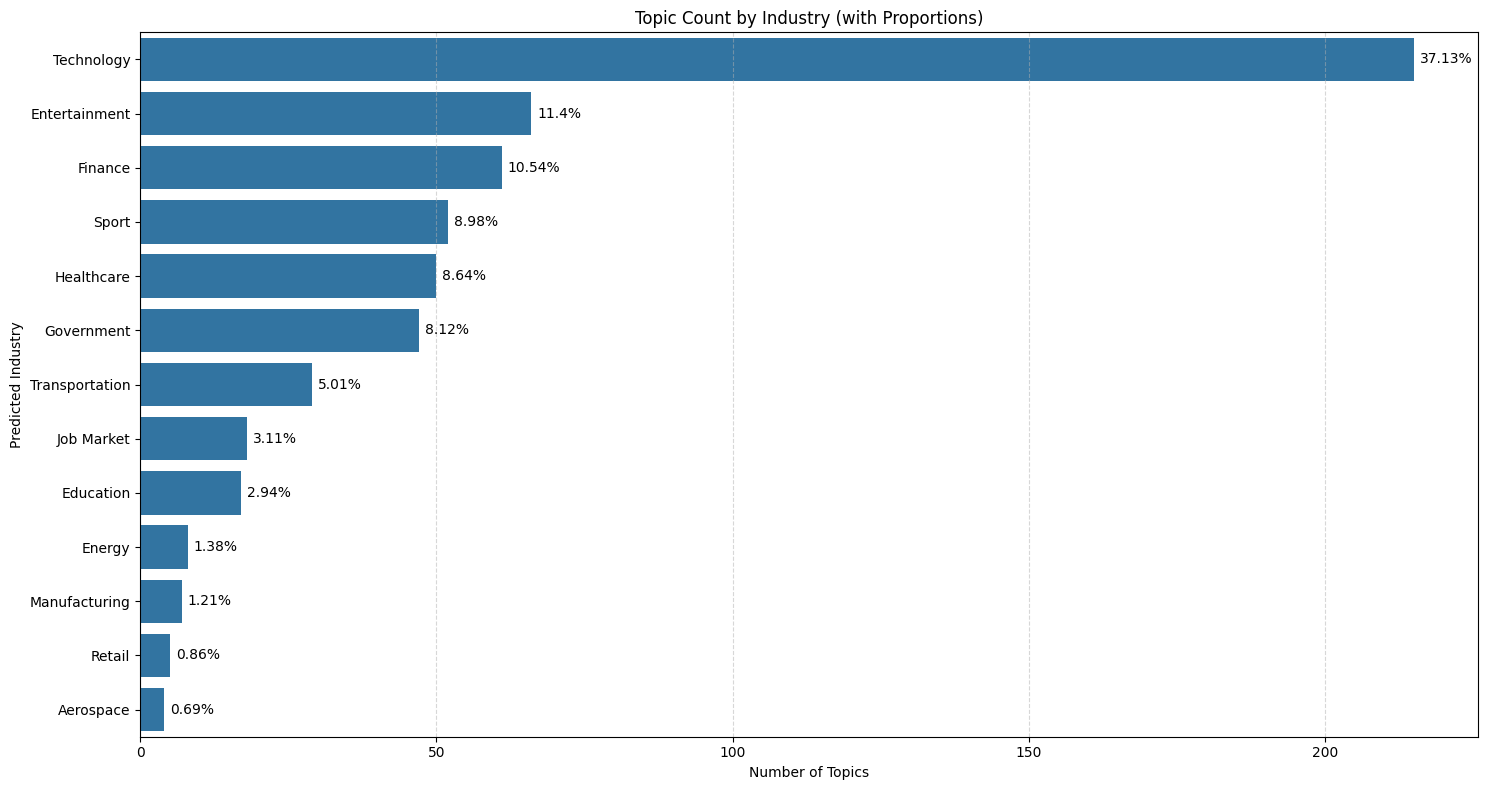

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Count topics by industry
industry_counts = topic_info_df['Predicted_Industry'].value_counts().reset_index()
industry_counts.columns = ['Predicted_Industry', 'Count']

# Calculate proportion
industry_counts["Proportion (%)"] = (
    industry_counts["Count"] / industry_counts["Count"].sum() * 100
).round(2)

# Plot
plt.figure(figsize=(15, 8))
barplot = sns.barplot(
    data=industry_counts,
    x="Count",
    y="Predicted_Industry",
)

plt.title("Topic Count by Industry (with Proportions)")
plt.xlabel("Number of Topics")
plt.ylabel("Predicted Industry")
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Add percentage labels next to each bar
for index, row in industry_counts.iterrows():
    barplot.text(
        row["Count"] + 1,    # Position to the right of the bar
        index,               # y-position of the bar
        f"{row['Proportion (%)']}%",
        va='center',
        fontsize=10
    )

plt.tight_layout()

# Save the figure (optional)
plt.savefig("topic_count_by_industry.png", dpi=300)
plt.show()

In [ ]:
df1 = pd.merge(df, topic_info_df[['Topic', 'Name', 'Predicted_Industry']], left_on='topic_BERT',right_on='Topic', how='left')

In [ ]:
df1.head()

,index,url,date,language,title,text,clean_text_with_punct,clean_text,topic_BERT,topic_BERT_prob,Topic,Name,Predicted_Industry
0,0,https://pjmedia.com/instapundit/494418/,2022-01-01,en,Instapundit » Blog Archive » HMM: An Advan...,\n\n\nInstapundit » Blog Archive » HMM: An...,Instapundit Blog Archive HMM: An Advanced AI G...,instapundit blog archive hmm advanced give un...,247,0.455750,247,247_instapundit_heather havrilesky_tcs daily_t...,Technology
1,1,https://www.vikatan.com/amp/story/automobile%2...,2022-01-01,en,Artificial Intelligence Reshaping the Automoti...,Artificial Intelligence Reshaping the Automoti...,Artificial Intelligence Reshaping the Automoti...,reshape automotive industryx vikatan original...,20,0.599253,20,20_automotive industry_automotive_automaker_el...,Sport
2,2,https://www.equities.com/news/exchange-listed-...,2022-01-01,en,Exchange Listed Funds - QRAFT AI Enhanced U.S....,\n\nExchange Listed Funds - QRAFT AI Enhanced ...,Exchange Listed Funds - QRAFT AI Enhanced U.S....,exchange list fund qraft enhance large cap et...,-1,0.000000,-1,-1_tech_industry_technology_feature,Technology
3,3,https://www.financialexpress.com/lifestyle/boo...,2022-01-01,en,Book Review: The Age of AI and Our Human Futur...,\n\nBook Review: The Age of AI and Our Human F...,Book Review: The Age of AI and Our Human Futur...,book review age human future henry kissinger ...,-1,0.000000,-1,-1_tech_industry_technology_feature,Technology
4,4,https://www.newsbreak.com/news/2470570042311/5...,2022-01-01,en,5 Places to Start a Career in Data Science in ...,5 Places to Start a Career in Data Science in ...,5 Places to Start a Career in Data Science in -,place start career datum science,492,1.000000,492,492_india magazine_analytic india_datum scient...,Technology


In [ ]:
len(df1)

185916

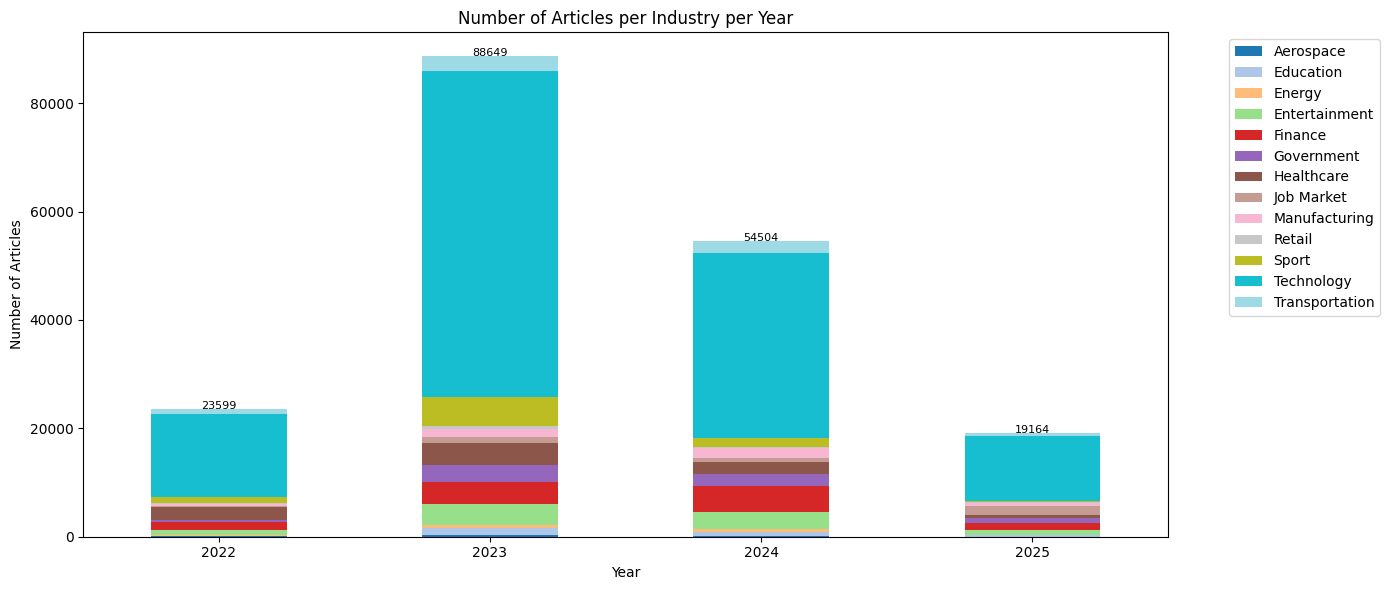

In [ ]:
# Convert date column to datetime and extract year
df1['date'] = pd.to_datetime(df['date'], errors='coerce')
df1['year'] = df['date'].dt.year

# Group by year and industry, and count the number of articles
industry_by_year = df1.groupby(['year', 'Predicted_Industry']).size().unstack(fill_value=0)

# Plot stacked bar chart
ax = industry_by_year.plot(kind='bar', stacked=True, figsize=(14, 6), colormap='tab20')

# Customize plot
plt.title('Number of Articles per Industry per Year')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.xticks(rotation=360)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
for i, year in enumerate(industry_by_year.index):
    total = industry_by_year.loc[year].sum()
    plt.text(i, total + 5, str(total), ha='center', fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
df1.to_parquet("/content/drive/MyDrive/Colab Notebooks/temp_data_md_bert_industry_v1.parquet", engine="pyarrow", index=False)

In [ ]:
import plotly.io as pio
pio.renderers.default = 'colab'

# visualization can get at the idea their may be little practical difference between clusters
fig = topic_model.visualize_topics()
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# original topics
original_topics = topic_model.get_topic_info()
print("Original topics:", len(original_topics))

# reduce topics
topic_model.reduce_topics(df['clean_text'].dropna().tolist(), nr_topics=100)

# check
reduced_topics = topic_model.get_topic_info()
print("Reduced topics:", len(reduced_topics))

# merge new key words
for i in range(20):
    print(f"Topic {i}: {topic_model.get_topic(i)}")

# Show top topics with keywords
top_topics = topic_model.get_topic_info()
top_keywords_per_topic = {
    row['Topic']: topic_model.get_topic(row['Topic'])
    for idx, row in top_topics.iterrows() if row['Topic'] != -1
}

# Display as DataFrame
top_topics_display = pd.DataFrame([
    {
        "Topic ID": topic_id,
        "Top Keywords": ", ".join([word for word, _ in words[:10]])
    }
    for topic_id, words in top_keywords_per_topic.items()
])

top_topics_display.head(20)

2025-05-20 08:47:06,353 - BERTopic - Topic reduction - Reducing number of topics


Original topics: 606


2025-05-20 08:47:06,504 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-20 08:52:39,151 - BERTopic - Representation - Completed ✓
2025-05-20 08:52:40,294 - BERTopic - Topic reduction - Reduced number of topics from 606 to 20


Reduced topics: 20
Topic 0: [('industry', np.float32(0.22529246)), ('tech', np.float32(0.21873246)), ('ai', np.float32(0.20326576)), ('technology', np.float32(0.17993557)), ('service', np.float32(0.1736985)), ('market', np.float32(0.15744518)), ('research', np.float32(0.15693404)), ('financial', np.float32(0.15515982)), ('feature', np.float32(0.15509264)), ('artificial intelligence', np.float32(0.15136841))]
Topic 1: [('lisk machine', np.float32(0.428217)), ('ai', np.float32(0.40558213)), ('love launch', np.float32(0.4003291)), ('launch come', np.float32(0.3991937)), ('sooncheck launch', np.float32(0.38118207)), ('machine learn', np.float32(0.3783775)), ('lisk', np.float32(0.37278122)), ('launch', np.float32(0.3618649)), ('artificial intelligence', np.float32(0.3573121)), ('feature currently', np.float32(0.32881325))]
Topic 2: [('market', np.float32(0.35491583)), ('broker', np.float32(0.31096166)), ('produkt', np.float32(0.30976593)), ('industry', np.float32(0.2996729)), ('company', np

,Topic ID,Top Keywords
0,0,"industry, tech, ai, technology, service, marke..."
1,1,"lisk machine, ai, love launch, launch come, so..."
2,2,"market, broker, produkt, industry, company, in..."
3,3,"salary heatmap, calculatorvisualizationsverifi..."
4,4,"smart eyewear, innovative eyewear, chatgpt app..."
5,5,"philanthropic fund, annual philanthropic, phil..."
6,6,"openai, openai say, microsoft openai, openai c..."
7,7,"tolerance, tolerance aim, tolerance base, prin..."
8,8,"nfl, week nfl, nfl prop, sportsline, sportslin..."
9,9,"solo musescore, com musescore, course musescor..."


In [ ]:
# Show top topics with keywords
top_topics = topic_model.get_topic_info()
top_keywords_per_topic = {
    row['Topic']: topic_model.get_topic(row['Topic'])
    for idx, row in top_topics.iterrows() if row['Topic'] != -1
}

# Display as DataFrame
top_topics_display = pd.DataFrame([
    {
        "Topic ID": topic_id,
        "Top Keywords": ", ".join([word for word, _ in words[:10]])
    }
    for topic_id, words in top_keywords_per_topic.items()
])

top_topics_display.head(20)

,Topic ID,Top Keywords
0,0,"ai, industry, tech, openai, feature, technolog..."
1,1,"ai, microsoft, software, machine, cloud, enter..."
2,2,"philanthropic, fundraising, funding, stakehold..."
3,3,"goudimel, musescore, claude, music, alm, piano..."
4,4,"christmas, xmas, santa, holiday, festive, clau..."
5,5,"tolerance, awareness, palestine, diversity, re..."
6,6,"hologram, holographic, holography, wimi, holo,..."
7,7,"dental, dentistry, dentist, tooth, oral, clini..."
8,8,"dementia, alzheimer, neurodegenerative, impair..."
9,9,"berry, marchant, eric, leadership, member, tea..."


### Job keyword

In [ ]:
# Job-level inference: look for keywords
job_keywords = ['lawyer', 'cashier', 'doctor', 'driver', 'teacher', 'nurse', 'installer', 'maintenance', 'finance', 'accountant']
for kw in job_keywords:
    df[kw] = df['clean_text'].str.contains(kw, case=False, na=False)

# Sum up by keyword
impact_counts = {kw: df[kw].sum() for kw in job_keywords}
print(impact_counts)


{'lawyer': 183, 'cashier': 5, 'doctor': 221, 'driver': 355, 'teacher': 283, 'nurse': 90, 'installer': 10, 'maintenance': 119, 'finance': 895, 'accountant': 18}


In [ ]:
job_keywords = ['teacher', 'nurse', 'driver', 'cashier', 'lawyer', 'accountant', 'engineer', 'installer']

for job in job_keywords:
    df[f'job_{job}'] = df['clean_text'].str.contains(job, case=False, na=False)


In [ ]:
job_sentiment = {}

for job in job_keywords:
    job_df = df[df[f'job_{job}']]
    job_sentiment[job] = {
        'count': len(job_df),
        'avg_sentiment': job_df['sentiment'].mean()
    }

pd.DataFrame(job_sentiment).T.sort_values(by='avg_sentiment')


,count,avg_sentiment
nurse,90.0,0.652650
lawyer,183.0,0.679231
teacher,283.0,0.684218
cashier,5.0,0.786920
driver,355.0,0.843490
accountant,18.0,0.861072
engineer,753.0,0.911081
installer,10.0,0.997250


In [ ]:
df['date'] = pd.to_datetime(df['date'])
df['year_month'] = df['date'].dt.to_period('M')
sentiment_over_time = df.groupby('year_month')['sentiment'].mean()


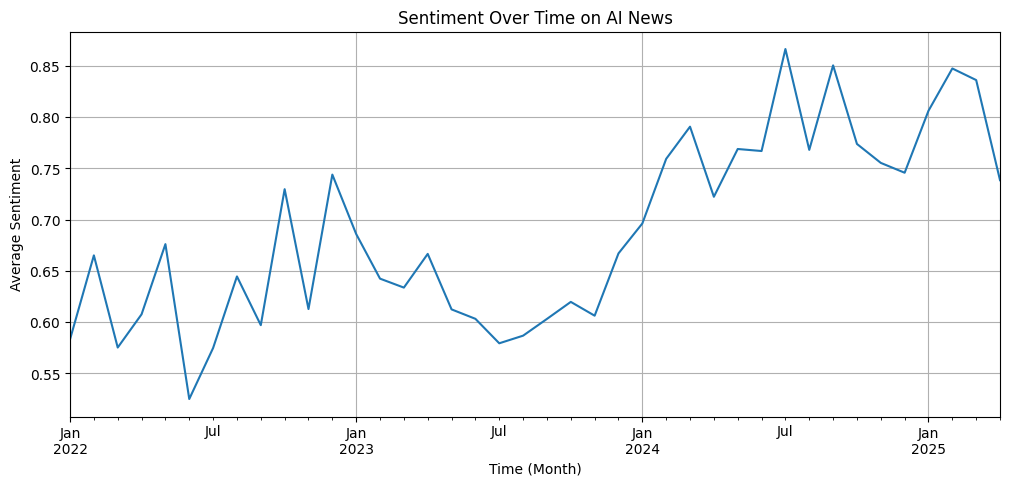

In [ ]:
import matplotlib.pyplot as plt

sentiment_over_time.plot(figsize=(12, 5), title='Sentiment Over Time on AI News')
plt.ylabel("Average Sentiment")
plt.xlabel("Time (Month)")
plt.grid(True)
plt.show()


In [ ]:
ai_tech_keywords = [
    "GPT", "GPT-3", "GPT-4", "ChatGPT", "generative AI", "large language model",
    "computer vision", "image recognition", "speech recognition",
    "chatbot", "virtual assistant", "robot", "automation",
    "robotic process automation", "RPA", "AI hiring tool", "resume screening",
    "predictive analytics", "machine learning", "deep learning", "NLP", "LLM"
]


In [ ]:
import re

def extract_ai_techs(text, tech_list):
    text = text.lower()
    matched = [kw for kw in tech_list if re.search(r'\b' + re.escape(kw.lower()) + r'\b', text)]
    return matched if matched else None

df['ai_tech_mentions'] = df['clean_text'].apply(lambda x: extract_ai_techs(x, ai_tech_keywords))


In [ ]:
from collections import Counter

tech_counts = Counter()
df['ai_tech_mentions'].dropna().apply(tech_counts.update)

import pandas as pd
tech_df = pd.DataFrame(tech_counts.items(), columns=["Technology", "Mentions"]).sort_values(by="Mentions", ascending=False)


In [ ]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['year_month'] = df['date'].dt.to_period('M')

# Explode the mentions to long format
df_exploded = df.dropna(subset=['ai_tech_mentions']).explode('ai_tech_mentions')

# Group by time and technology
time_series = df_exploded.groupby(['year_month', 'ai_tech_mentions']).size().reset_index(name='count')


In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

def extract_ents(text):
    doc = nlp(text)
    return [ent.text for ent in doc.ents if ent.label_ in ['ORG', 'PERSON', 'GPE']]

df['named_entities'] = df['clean_text'].apply(extract_ents)


In [ ]:
def extract_entities(text):
    doc = nlp(text)
    entities = {"ORG": [], "PERSON": [], "GPE": []}
    for ent in doc.ents:
        if ent.label_ in entities:
            entities[ent.label_].append(ent.text)
    return entities

df['named_entities'] = df['clean_text'].apply(extract_entities)

In [ ]:
from itertools import chain
from collections import Counter

# ORG
orgs = list(chain.from_iterable(
    df['named_entities'].dropna().apply(lambda x: x.get('ORG', []))
))

# PERSON
people = list(chain.from_iterable(
    df['named_entities'].dropna().apply(lambda x: x.get('PERSON', []))
))

# GPE
gpes = list(chain.from_iterable(
    df['named_entities'].dropna().apply(lambda x: x.get('GPE', []))
))

# Top counts
top_orgs = Counter(orgs).most_common(10)
top_people = Counter(people).most_common(10)
top_locations = Counter(gpes).most_common(10)



In [ ]:
print("Top ORGs:", top_orgs)
print("Top People:", top_people)
print("Top Locations:", top_locations)

Top ORGs: [('microsoft', 1937), ('google', 1452), ('gpt', 816), ('ibm', 515), ('npr', 469), ('pbs', 394), ('intel', 384), ('congress', 362), ('chevron', 315), ('fda', 313)]
Top People: [('don', 738), ('sam altman', 472), ('doesn', 362), ('eu', 347), ('taylor', 316), ('donald trump', 230), ('joe biden', 179), ('max', 177), ('don miss', 157), ('gpu', 145)]
Top Locations: [('india', 2655), ('us', 1889), ('china', 1839), ('new york', 1202), ('california', 935), ('washington', 840), ('uk', 836), ('canada', 790), ('russia', 762), ('france', 757)]


In [ ]:
# Success: tech mentions + positive sentiment
success = df[(df['sentiment'] > 0.5) & df['ai_tech_mentions'].notna()]
failure = df[(df['sentiment'] < -0.5) & df['ai_tech_mentions'].notna()]

# Examples
success_examples = success[['date', 'clean_text', 'ai_tech_mentions']].head(5)
failure_examples = failure[['date', 'clean_text', 'ai_tech_mentions']].head(5)


In [ ]:
success_examples

,date,clean_text,ai_tech_mentions
0,2023-05-20,infogain ai business solutions now available i...,"[generative AI, automation, machine learning]"
2,2023-07-25,yang lan interviews academics on ai developmen...,"[ChatGPT, chatbot]"
7,2024-10-09,meta debuts new generative ai tools for video ...,[generative AI]
8,2023-03-30,can ai benefit drinks retailers drinks retaili...,[automation]
10,2024-10-08,samsung electronics apologises for disappointi...,[generative AI]


In [ ]:
quotes = {}

for topic_id in df['topic'].unique()[:5]:  # Limit to top 5 topics
    subset = df[df['topic'] == topic_id]

    if subset.empty:
        continue

    topic_keywords = topic_model.get_topic(topic_id)
    if topic_keywords:
        topic_name = " / ".join([word for word, _ in topic_keywords[:5]])
    else:
        topic_name = f"Topic {topic_id}"

    quotes[topic_name] = {
        'positive_example': subset.sort_values(by='sentiment', ascending=False).iloc[0]['clean_text'],
        'negative_example': subset.sort_values(by='sentiment', ascending=True).iloc[0]['clean_text']
    }
